# Market Basket Analysis

- Este conjunto de dados contém todas as transações ocorridas entre 01/12/2010 e 09/12/2011 em um varejo on-line do Reino Unido. A empresa vende principalmente presentes exclusivos para todas as ocasiões e muitos clientes da empresa são atacadistas.

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importação do dataset
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


- InvoiceNo: Número da fatura. Nominal, um número integral de 6 dígitos atribuído exclusivamente a cada transação. Se este código começar com a letra 'c', indica um cancelamento.
- StockCode: Código do produto (item). Nominal, um número integral de 5 dígitos atribuído exclusivamente a cada produto distinto.
- Description: Nome do produto (item). Nominal.
- Quantity: Quantidade de cada produto (item) por transação. Numérico.
- InvoiceDate: Data e hora da transação. Numérico, o dia e a hora em que cada transação foi gerada.
- UnitPrice: Preço unitário. Numérico, preço do produto por unidade em libras esterlinas.
- CustomerID: Número do cliente. Nominal, um número integral de 5 dígitos atribuído exclusivamente a cada cliente.
- Country: Nome do país. Nominal, o nome do país em que cada cliente reside.

Precisamos realizar algumas limpezas no dataset. Primeiro, algumas das descrições têm espaços que precisam ser removidos, removeremos também as linhas que não têm números de fatura e as transações de cancelamento (aquelas com números de fatura que contêm C).

In [3]:
# Remoção dos espaços em branco
df['Description'] = df['Description'].str.strip()

# Dropa as linhas sem número de fatura
df = df.dropna(axis=0, subset=['InvoiceNo'])

# Dropa as transações de cancelamento
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

Agora iremos verificar a quantia de linhas, os tipos de dados e se possuímos valores vazios em nosso dataset.

In [4]:
# Número de linhas e colunas
df.shape

(532621, 8)

In [5]:
# Verifica os tipos de dados
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [6]:
# Verifica os dados vazios
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1455
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64

Note que possuímos 1455 compras sem um produto associado e 134 mil compras sem um CustomerID associado. Por conta do algorítimo de Market Basket considerar apenas os items preenchidos e não utilizar o CustomerID, iremos manter os dados na base.

# Análise Exploratória

Como irei utilizar apenas as vendas para França no algoritimo apriori, a exploração será totalmente realizada em cima dos valores do país.

In [7]:
df_exploration = df[df['Country'] == 'France']

In [8]:
df_exploration.shape

(8408, 8)

De 532 mil notas fiscais registradas na base, iremos trabalhar com 8.4 mil relacionadas a França.

Vamos agora analisar algumas informações características da base

In [9]:
# Criação da variável Ano/Mês
df_exploration['YearMonth'] = pd.DatetimeIndex(df_exploration['InvoiceDate']).year.map(str) + '-' + pd.DatetimeIndex(df_exploration['InvoiceDate']).month.map(str)

# Criação da variável de valor vendido
df_exploration['SellValue'] = df_exploration['UnitPrice'] * df_exploration['Quantity']

Total de Vendas no Período: 112104




Text(0.5, 1.0, 'TOTAL DE PRODUTOS VENDIDOS POR MÊS')

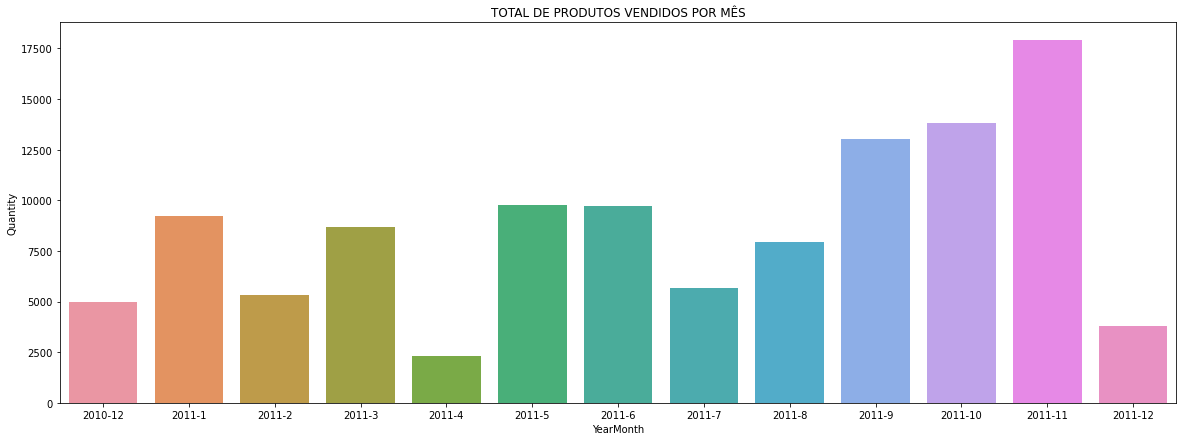

In [10]:
# Total de vendas por mês
print('Total de Vendas no Período: ' + str(df_exploration['Quantity'].sum()))
print('\n')

plt.figure(figsize = (20, 7))
sns.barplot(data = df_exploration[['YearMonth', 'Quantity']].groupby('YearMonth').sum().reset_index(), 
            x = 'YearMonth', y = 'Quantity',
           order = df_exploration['YearMonth'].unique())
plt.title('TOTAL DE PRODUTOS VENDIDOS POR MÊS')

Além da França ser responsável pela venda de 112 mil produtos dentro do período, notamos um aumento expressivo nas vendas entre os meses de Setembro e Novembro, uma hipótese é de que seja o período onde os varejistas começam a construir o estoque para os feriados de fim de ano.

Valor Arrecadado no Período: 209715.11




Text(0.5, 1.0, 'VALOR ARRECADADO COM VENDAS POR MÊS')

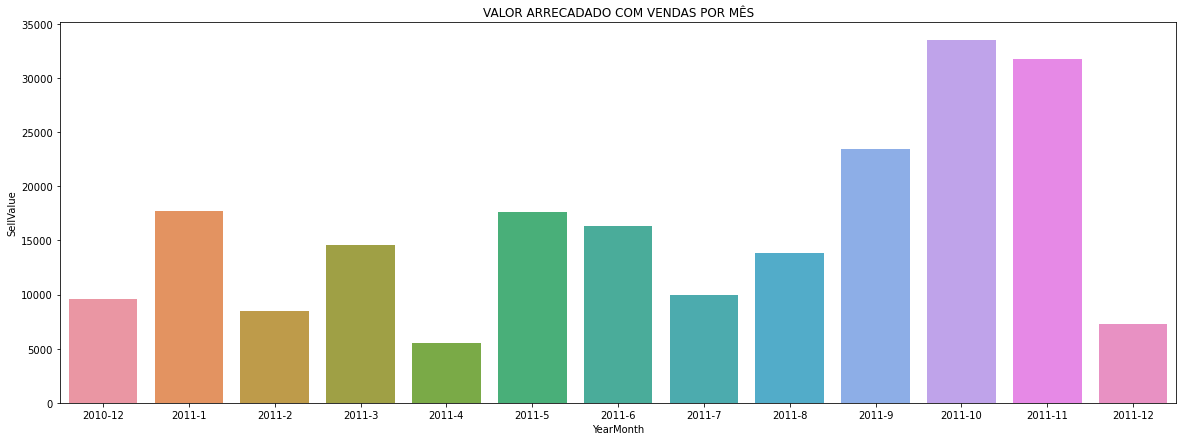

In [11]:
# Valor arrecadado por mês
print('Valor Arrecadado no Período: ' + str(df_exploration['SellValue'].sum().round(2)))
print('\n')

plt.figure(figsize = (20, 7))
sns.barplot(data = df_exploration[['YearMonth', 'SellValue']].groupby('YearMonth').sum().reset_index(), 
            x = 'YearMonth', y = 'SellValue',
           order = df_exploration['YearMonth'].unique())
plt.title('VALOR ARRECADADO COM VENDAS POR MÊS')

O comportamento no ticket médio é bem semelhante ao do total de vendas, com uma curiosidade: O mês de Outubro possui um valor arrecadado com as vendas superior ao mês de Novembro, que lidera a janela com o maior número de vendas.

Text(0.5, 1.0, 'TOTAL DE PRODUTOS VENDIDOS POR MÊS')

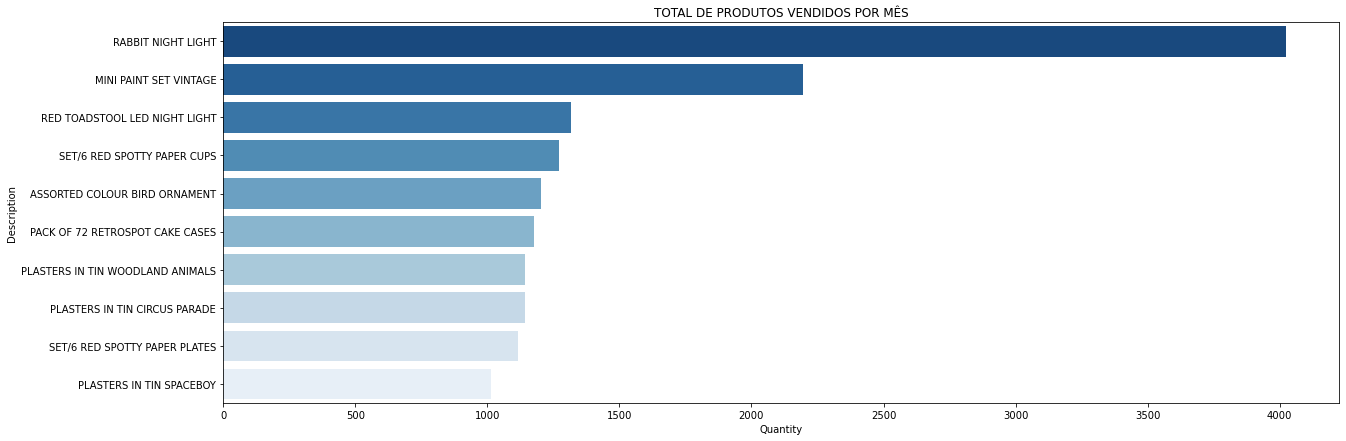

In [12]:
# Produtos mais vendidos
plt.figure(figsize = (20, 7))
sns.barplot(data = df_exploration[['Description', 'Quantity']].groupby('Description').sum().reset_index().sort_values('Quantity', ascending = False).head(10), 
            y = 'Description', x = 'Quantity', palette = 'Blues_r')
plt.title('TOTAL DE PRODUTOS VENDIDOS POR MÊS')

O produto mais vendido é um abajur em formato de coelho... Realmente uma excelente lembrança para se presentear, principalmente para quem possui filhos pequenos.
Além disso, observamos um 'kit' de produtos que são adquiridos, Copos e Pratos vermelhos.

Text(0.5, 1.0, 'PRODUTO MAIS CARO')

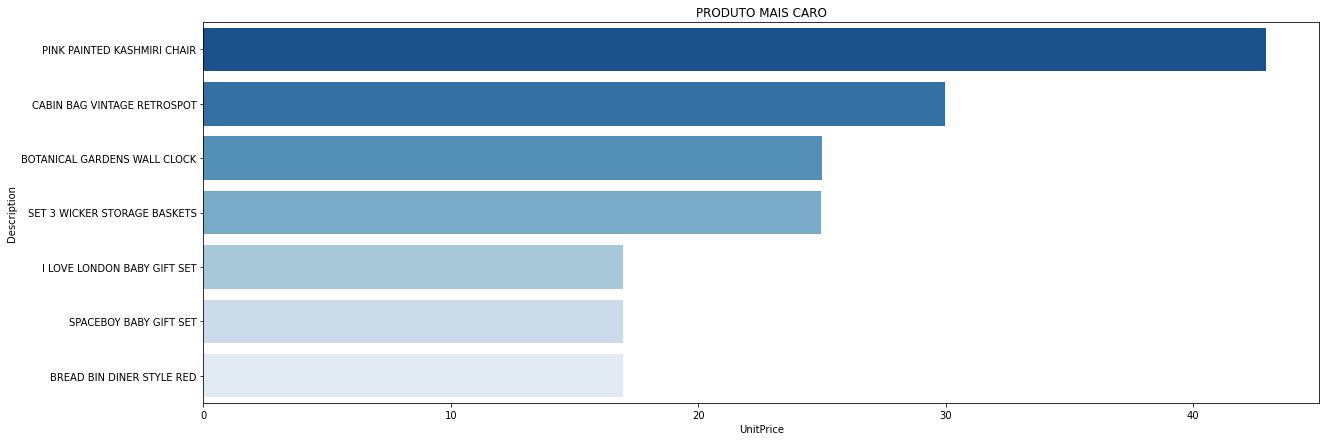

In [13]:
# Retira da base as informações de carregamento
df_exploration = df_exploration[(df_exploration['Description'] != 'Manual') &
                                (df_exploration['Description'] != 'CARRIAGE') &
                                (df_exploration['Description'] != 'POSTAGE')]

# Produtos mais caro
plt.figure(figsize = (20, 7))
sns.barplot(data = df_exploration.sort_values('UnitPrice', ascending = False).head(10), y = 'Description', x = 'UnitPrice', palette = 'Blues_r')
plt.title('PRODUTO MAIS CARO')

O produto mais caro é uma cadeira rosa de kashmir, bem chique e custando cerca de 45 libras esterlinas... Será que encontramos uma boa associação de produtos para aumentar o ticket médio?

# Aplicação do Algoritmo Apriori

# O que são Algoritmos Apriori?

Imagine que você está trabalhando como vendedor de um supermercado e deseja descobrir algum método para aumentar suas vendas, aumentando assim os lucros. Para isso você resolve tentar "induzir" seu cliente a comprar produtos que ele vá consumir ao mesmo tempo, colocando-os próximos nos mercados.

Com essa ideia em mente, você decide testar sua hipótese com os produtos do dia-a-dia dos brasileiros, o pão e a manteiga. Para fazer isso você move as prateleiras onde os pães ficam para próximo de onde a manteiga fica. Passado um tempo, você percebe que os clientes estão comprando mais pão e manteiga juntos.

Com o sucesso das vendas do pão e da manteiga, você decide explorar mais essa ideia de produtos que podem ser comprados juntos. No meio das suas pesquisas, descobre que fraldas e cervejas são produtos que saem bastante juntos. Sem entender muito bem o motivo disso, você rapidamente coloca a prateleira das fraldas perto da prateleira de cerveja, fazendo a associação de que pais estressados com seus bebês tendem a comprar cerveja para relaxar, o que faz suas vendas dispararem.

Cada linha da amostra contém uma transação identificada por um ID, onde se a coluna referente ao produto (Cerveja, Fralda, Chiclete, Refrigerante e Salgadinho) estiver marcada com 1 significa que esse produto foi comprado nessa transação, 0 caso o contrário. Com isso entendido, podemos definir então o que seria uma Regra de Associação, que nada mais é que um método de explorar relações entre Itens em conjuntos de dados. Vamos definir os seguintes termos para Regra de Associação:

- I (Itens): conjunto dos seus n atributos {i_1, i_2, …, i_n};
- D (Database): conjunto das m transações {t_1, t_2, …, t_m};
- Toda transação t_i, é única em D e consiste em um subconjunto dos Itens I;
- Vamos Definir uma Regra de Associação como a relação (X => Y) , onde X e Y são subconjuntos de I. Eles não podem ter nenhum elemento em comum.
- X é chamado de antecedente e Y da consequência da Regra.

Com isso definido, considere a transação de ID igual a 2, podemos ter a seguinte Regra de Associação: {Beer} => {Diaper}. Essa é a Regra de Associação que define que nessa transação, quem comprou Cerveja também comprou Fralda.
Nesse ponto, se você começar a montar as Regras de Associação na sua cabeça, perceberá que mesmo para um conjunto de dados pequeno, existem muitas Regras. O desafio agora é encontrar um modo de selecionar as regras relevantes.

## Aplicação do Market Basket

Precisamos consolidar os itens em 1 transação por linha com cada produto (1 hot encoded). Para manter o conjunto de dados pequeno, só estou olhando as vendas para a França.

In [14]:
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket.sample(5)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
580986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
570672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
566736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Existem muitos zeros nos dados e precisamos garantir que quaisquer valores positivos sejam convertidos em 1 e os demais em 0. Esta etapa concluirá a codificação dos dados e removerá a coluna de postagem. 

In [15]:
# Cria a função de 1 hot encode.
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

# Aplica a função
basket_sets = basket.applymap(encode_units)

# Dropa a coluna POSTAGE
basket_sets = basket_sets.drop('POSTAGE', axis=1)

## Medidas de avaliação
- Support é a frequência relativa em que as regras aparecem. Normalmente, se procura valores altos de support para garantir que seja um relacionamento útil. No entanto, pode haver casos em que um support baixo seja necessário se estiver tentando encontrar relacionamentos "ocultos".

- Confidence é uma medida da confiabilidade de regras. Uma confidence de 0,5 significaria que em 50% dos casos em que foram compradas fraldas e chicletes, a compra também incluía cerveja e batatas fritas. Para recomendação do produtos, uma confiança de 50% pode ser perfeitamente aceitável, mas em uma situação médica, esse nível pode não ser alto o suficiente.

- Lift é a razão entre o support observado e o esperado se as duas regras forem independentes. A regra básica é que um valor de lift próximo a 1 significa que as regras eram completamente independentes. Os valores de elevação > 1 geralmente são mais "interessantes" e podem ser indicativos de um padrão de regra útil.

Agora que os dados estão estruturados corretamente, podemos gerar conjuntos de itens frequentes com suporte de pelo menos 7% (esse número foi escolhido para que eu possa obter exemplos úteis suficientes)

In [16]:
frequent_itemsets = apriori(basket_sets, min_support = 0.07, use_colnames = True)

A etapa final é gerar as regras com o support, confidence e lift correspondentes

In [17]:
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold=1)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
5,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
6,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.099490,0.125000,0.071429,0.717949,5.743590,0.058992,3.102273
7,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.125000,0.099490,0.071429,0.571429,5.743590,0.058992,2.101190
8,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.137755,0.168367,0.089286,0.648148,3.849607,0.066092,2.363588
9,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.168367,0.137755,0.089286,0.530303,3.849607,0.066092,1.835747


Agora, a parte complicada é descobrir o que isso nos diz. Por exemplo, podemos ver que existem algumas regras com um valor alto de lift, o que significa que ocorre com mais frequentemente do que seria esperado, dado o número de transações e combinações de produtos. Também podemos ver vários onde a confidence também é alta. Essa parte da análise é onde o conhecimento do domínio será útil. Como não tenho isso, procurarei apenas alguns exemplos ilustrativos.

Podemos filtrar o dataframe usando o código padrão dos pandas. Nesse caso, procurei lift alta (6) e confidence alta (0,8)

In [18]:
rules[(rules['lift'] >= 6) &
      (rules['confidence'] >= 0.8)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
17,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.127551,0.132653,0.102041,0.800000,6.030769,0.085121,4.336735
18,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.127551,0.137755,0.122449,0.960000,6.968889,0.104878,21.556122
19,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.137755,0.127551,0.122449,0.888889,6.968889,0.104878,7.852041
20,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975000,7.077778,0.085433,34.489796
21,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959
22,"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.122449,0.132653,0.099490,0.812500,6.125000,0.083247,4.625850


Observando as regras, parece que os despertadores verdes e vermelhos são comprados juntos, e, os copos, guardanapos e pratos de papel vermelho são comprados juntos também.

Nesse ponto, convém verificar as oportunidades existentes para usar a popularidade de um produto para impulsionar as vendas de outro. 

In [19]:
print('Total de Despertadores Verdes: ' + str(basket['ALARM CLOCK BAKELIKE GREEN'].sum()))
print('Total de Despertadores Vermelhos: ' + str(basket['ALARM CLOCK BAKELIKE RED'].sum()))

Total de Despertadores Verdes: 340.0
Total de Despertadores Vermelhos: 316.0


## Podemos ver que vendemos 340 Despertadores Verdes, mas apenas 316 Despertadores Vermelhos, será que podemos gerar mais vendas de Despertadores Vermelhos por meio da recomendação?